In [1]:
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
#https://pyramid-arima.readthedocs.io/en/latest/_submodules/arima.html
import numpy
from numpy import newaxis
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pyramid.arima import auto_arima

Using TensorFlow backend.
/home/fastovetsilya/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


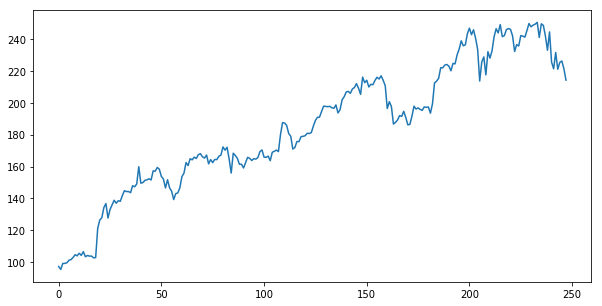

In [2]:
dataset = pandas.read_csv('NVDA.csv', usecols=[1], engine='python', skipfooter=3)
dataset = numpy.flipud(dataset)[1::]
plt.figure(figsize=(10,5))
plt.plot(dataset)
plt.show()
#dataset = dataframe.values
dataset = dataset.astype('float32')

In [3]:
# fix random seed for reproducibility
#numpy.random.seed(7)

In [4]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

166 82


In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [7]:
# reshape into X=t and Y=t+1
look_back = 15
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [8]:
trainX.shape

(150, 15)

In [9]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [10]:
trainX.shape

(150, 1, 15)

In [11]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(64, input_shape=(1, look_back)))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=1, verbose=2)

Epoch 1/200
 - 1s - loss: 0.0203
Epoch 2/200
 - 0s - loss: 0.0056
Epoch 3/200
 - 0s - loss: 0.0052
Epoch 4/200
 - 0s - loss: 0.0053
Epoch 5/200
 - 0s - loss: 0.0040
Epoch 6/200
 - 0s - loss: 0.0048
Epoch 7/200
 - 0s - loss: 0.0046
Epoch 8/200
 - 0s - loss: 0.0051
Epoch 9/200
 - 0s - loss: 0.0038
Epoch 10/200
 - 0s - loss: 0.0042
Epoch 11/200
 - 0s - loss: 0.0035
Epoch 12/200
 - 0s - loss: 0.0031
Epoch 13/200
 - 0s - loss: 0.0031
Epoch 14/200
 - 0s - loss: 0.0034
Epoch 15/200
 - 0s - loss: 0.0038
Epoch 16/200
 - 0s - loss: 0.0031
Epoch 17/200
 - 0s - loss: 0.0033
Epoch 18/200
 - 0s - loss: 0.0037
Epoch 19/200
 - 0s - loss: 0.0039
Epoch 20/200
 - 0s - loss: 0.0028
Epoch 21/200
 - 0s - loss: 0.0034
Epoch 22/200
 - 0s - loss: 0.0026
Epoch 23/200
 - 0s - loss: 0.0026
Epoch 24/200
 - 0s - loss: 0.0025
Epoch 25/200
 - 0s - loss: 0.0025
Epoch 26/200
 - 0s - loss: 0.0024
Epoch 27/200
 - 0s - loss: 0.0024
Epoch 28/200
 - 0s - loss: 0.0027
Epoch 29/200
 - 0s - loss: 0.0024
Epoch 30/200
 - 0s - lo

In [12]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 4.13 RMSE
Test Score: 7.50 RMSE


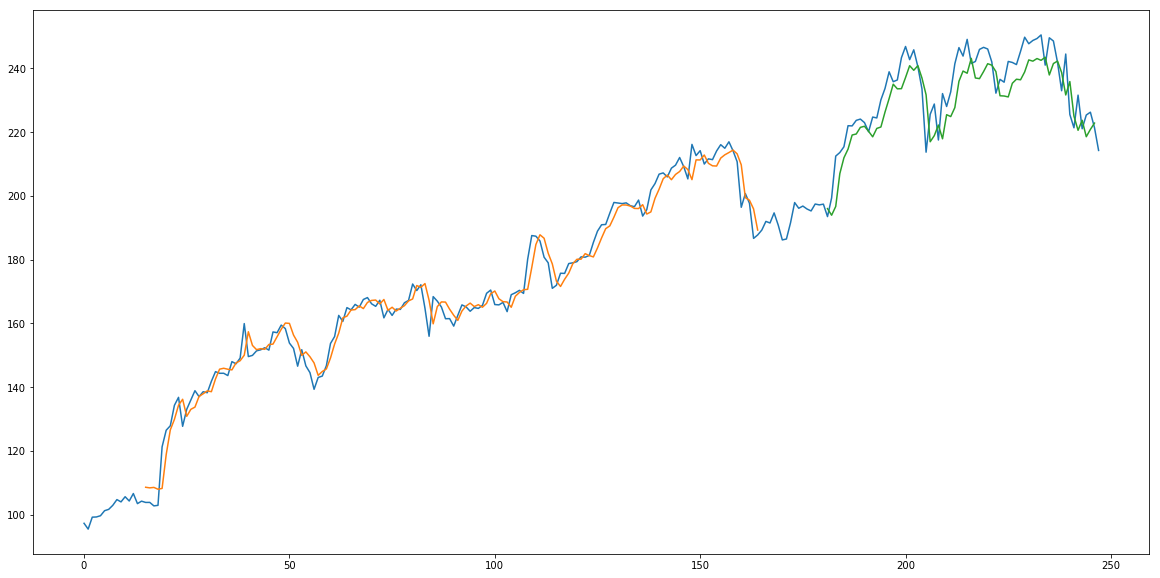

In [13]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [14]:
train2 = dataset
trainX2, trainY2 = create_dataset(train2, look_back)
trainX2 = numpy.reshape(trainX2, (trainX2.shape[0], 1, trainX2.shape[1]))
trainX2.shape, trainY2.shape

((232, 1, 15), (232,))

In [15]:
model2 = Sequential()
model2.add(LSTM(64, input_shape=(1, look_back)))
model2.add(Dropout(0.3))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')
model2.fit(trainX2, trainY2, epochs=200, batch_size=1, verbose=2)

Epoch 1/200
 - 2s - loss: 0.0263
Epoch 2/200
 - 1s - loss: 0.0099
Epoch 3/200
 - 1s - loss: 0.0080
Epoch 4/200
 - 1s - loss: 0.0096
Epoch 5/200
 - 1s - loss: 0.0066
Epoch 6/200
 - 1s - loss: 0.0060
Epoch 7/200
 - 1s - loss: 0.0056
Epoch 8/200
 - 1s - loss: 0.0071
Epoch 9/200
 - 1s - loss: 0.0064
Epoch 10/200
 - 1s - loss: 0.0062
Epoch 11/200
 - 1s - loss: 0.0059
Epoch 12/200
 - 1s - loss: 0.0048
Epoch 13/200
 - 1s - loss: 0.0060
Epoch 14/200
 - 1s - loss: 0.0056
Epoch 15/200
 - 1s - loss: 0.0047
Epoch 16/200
 - 1s - loss: 0.0048
Epoch 17/200
 - 1s - loss: 0.0051
Epoch 18/200
 - 1s - loss: 0.0047
Epoch 19/200
 - 1s - loss: 0.0042
Epoch 20/200
 - 1s - loss: 0.0042
Epoch 21/200
 - 1s - loss: 0.0049
Epoch 22/200
 - 1s - loss: 0.0046
Epoch 23/200
 - 1s - loss: 0.0042
Epoch 24/200
 - 1s - loss: 0.0043
Epoch 25/200
 - 1s - loss: 0.0044
Epoch 26/200
 - 1s - loss: 0.0036
Epoch 27/200
 - 1s - loss: 0.0044
Epoch 28/200
 - 1s - loss: 0.0039
Epoch 29/200
 - 1s - loss: 0.0027
Epoch 30/200
 - 1s - lo

In [16]:
# make predictions
trainPredict2 = model2.predict(trainX2)
# invert predictions
trainPredict2 = scaler.inverse_transform(trainPredict2)
trainY2 = scaler.inverse_transform([trainY2])
# calculate root mean squared error
trainScore2 = math.sqrt(mean_squared_error(trainY2, trainPredict2.T))
print('Train Score2: %.2f RMSE' % (trainScore2))

Train Score2: 5.64 RMSE


In [17]:
trainY2.shape, trainPredict2.shape

((1, 232), (232, 1))

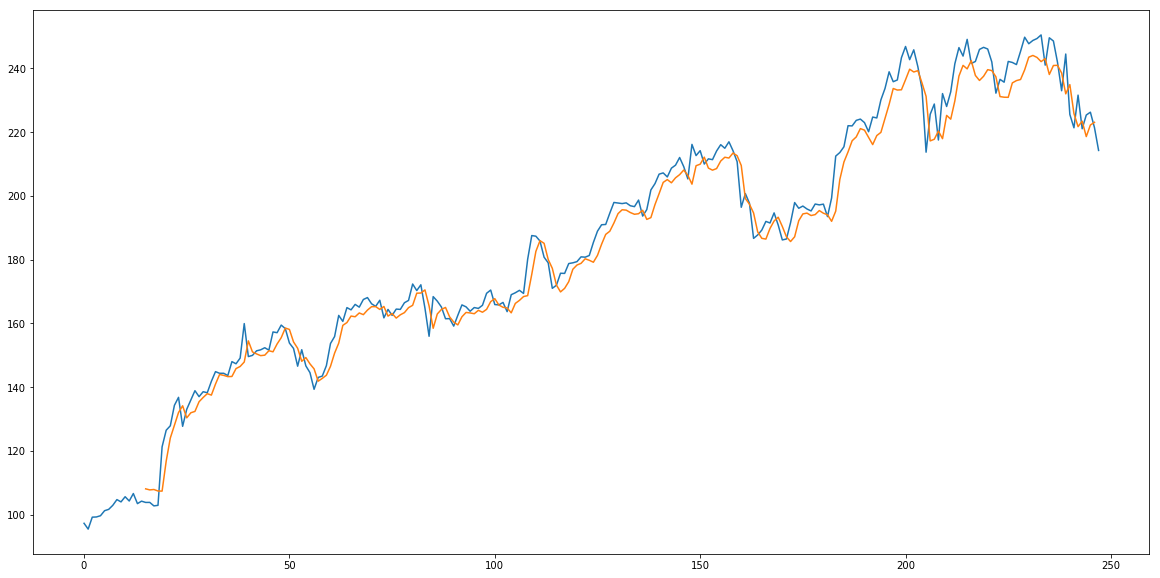

In [18]:
# shift train predictions for plotting
trainPredictPlot2 = numpy.empty_like(dataset)
trainPredictPlot2[:, :] = numpy.nan
trainPredictPlot2[look_back:len(trainPredict2)+look_back, :] = trainPredict2

# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot2)
plt.show()

In [19]:
import pandas as pd
#from plotly.plotly import plot_mpl
#from statsmodels.tsa.seasonal import seasonal_decompose

In [20]:
#trainPredict2 = pd.DataFrame(trainPredict2)
#result = seasonal_decompose(trainPredict2, model='multiplicative')
#fig = result.plot()
#plot_mpl(fig)

In [21]:
numpy.savetxt("LSTM_Predicted.csv", trainPredict2, delimiter=",")

In [22]:
stepwise_model = auto_arima(trainPredict2, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1149.829, BIC=1167.063, Fit time=0.978 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=1218.789, BIC=1232.576, Fit time=0.235 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=1152.911, BIC=1166.698, Fit time=0.780 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=1149.342, BIC=1170.023, Fit time=1.271 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 7); AIC=1220.716, BIC=1237.950, Fit time=0.333 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=1151.399, BIC=1175.526, Fit time=3.190 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=1291.734, BIC=1305.521, Fit time=0.162 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 2, 7); AIC=1149.480, BIC=1177.054, Fit time=2.946 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 

In [23]:
print(stepwise_model.aic())

1147.79555889


In [24]:
n_periods = 30
future_forecast = stepwise_model.predict(n_periods=n_periods)
print(future_forecast)
trainPredict2full = numpy.append(trainPredict2,future_forecast)

[ 223.47638478  223.56020187  223.89133134  224.4320785   225.12118797
  225.04156544  224.24444662  224.65647402  223.5860182   223.35470281
  223.98648271  224.00973012  224.31760857  223.67369274  224.05074661
  223.07743822  222.87589452  223.46303914  223.52784119  223.75732738
  223.06169917  223.40846855  222.38983095  222.15063018  222.70859053
  222.73439378  222.93853963  222.21453303  222.530484    221.48274114]


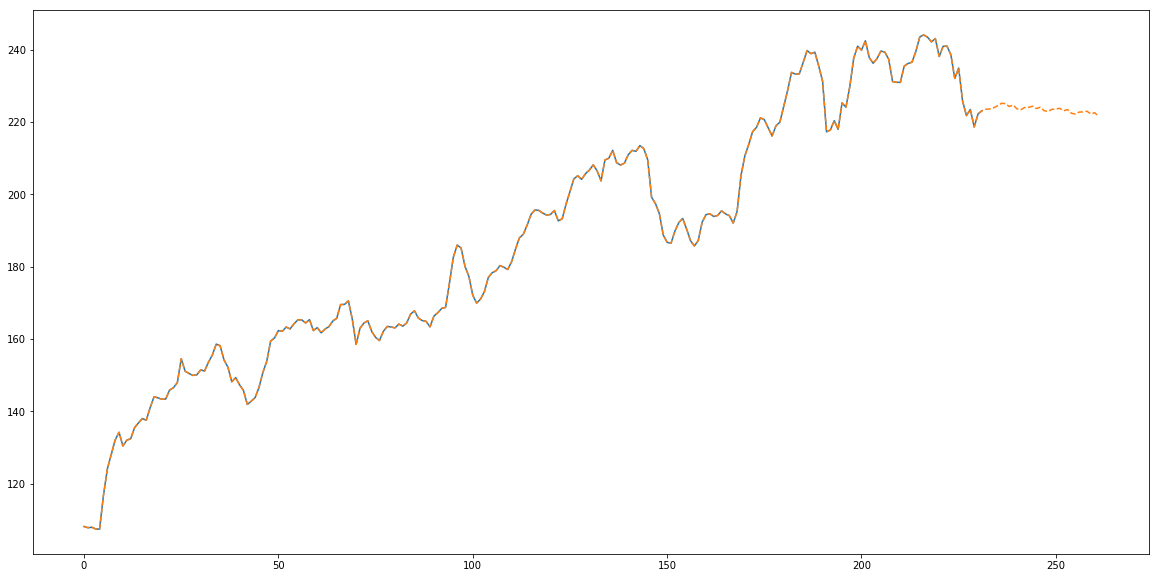

In [25]:
plt.figure(figsize=(20,10))
plt.plot(trainPredict2)
plt.plot(trainPredict2full, '--')
plt.show()